In [1]:
%load_ext autoreload
%autoreload

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import prim
import seaborn as sns
from sklearn import mixture
import os
from clustering_and_prim_tools import *
from SALib.analyze import sobol
from SALib.sample import saltelli

In [3]:
%matplotlib inline

In [4]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [5]:
invfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_cired_output_data/outputs_investments_billion_usd/"
imaclimfolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_cired_output_data/outputs_Imaclim/"
physicalinfrafolder = "C:/Users/WB451855/OneDrive - WBG/!infra_needs_data/transport_cired_output_data/outputs_investments_module_physical_stock/"

# First I look at the results from the Imaclim model only (output = transport activity but no investment need)

In [6]:
os.listdir(imaclimfolder)

['results_transports_Imaclim_ASIA.csv',
 'results_transports_Imaclim_CIS.csv',
 'results_transports_Imaclim_LAM.csv',
 'results_transports_Imaclim_MAF.csv',
 'results_transports_Imaclim_OCDE.csv',
 'results_transports_Imaclim_WORLD.csv']

In [7]:
pd.options.display.max_seq_items = 2000

In [8]:
all_ima_data = pd.DataFrame()
for myfilename in os.listdir(imaclimfolder):
    if "WORLD" in myfilename:
        continue
    myfile = pd.read_csv(imaclimfolder+"\\"+myfilename,sep=";")
    myinfo = myfilename.replace(".csv",'').split("_")
    myfile["region"] = myinfo[3]
    all_ima_data = all_ima_data.append(myfile)

In [9]:
all_ima_data.Variable.unique()

array(['Population', 'CO2_em_tot', 'CO2_em_trans', 'PIB',
       'passenger_activity', 'freight_activity', 'pkm_OT', 'pkm_auto',
       'pkm_air', 'fret_air', 'fret_OT', 'fret_mer'], dtype=object)

In [10]:
indexes_ima = ['//combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable', 'Unit','region']

In [11]:
indexes_ima2 = ['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable','region','year']

In [12]:
all_ima_data = all_ima_data.set_index(indexes_ima)
all_ima_data.columns.name='year'
all_ima_data = all_ima_data.drop(['2001', '2002', '2003', '2004',
       '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013',
       '2014','2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
       '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
       '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
       '2077', '2078', '2079', '2080', '2081', '2082', '2083', '2084', '2085',
       '2086', '2087', '2088', '2089', '2090', '2091', '2092', '2093', '2094',
       '2095', '2096', '2097', '2098', '2099'],axis=1)
all_ima_data = all_ima_data.stack('year')
all_ima_data.name = 'value'

In [13]:
out = all_ima_data.reset_index().drop(['Unit','//combi'],axis=1).set_index(indexes_ima2).unstack('Variable').value

In [14]:
out.columns

Index(['CO2_em_tot', 'CO2_em_trans', 'PIB', 'Population', 'freight_activity',
       'fret_OT', 'fret_air', 'fret_mer', 'passenger_activity', 'pkm_OT',
       'pkm_air', 'pkm_auto'],
      dtype='object', name='Variable')

## Data vizualisation for freight and passenger activity

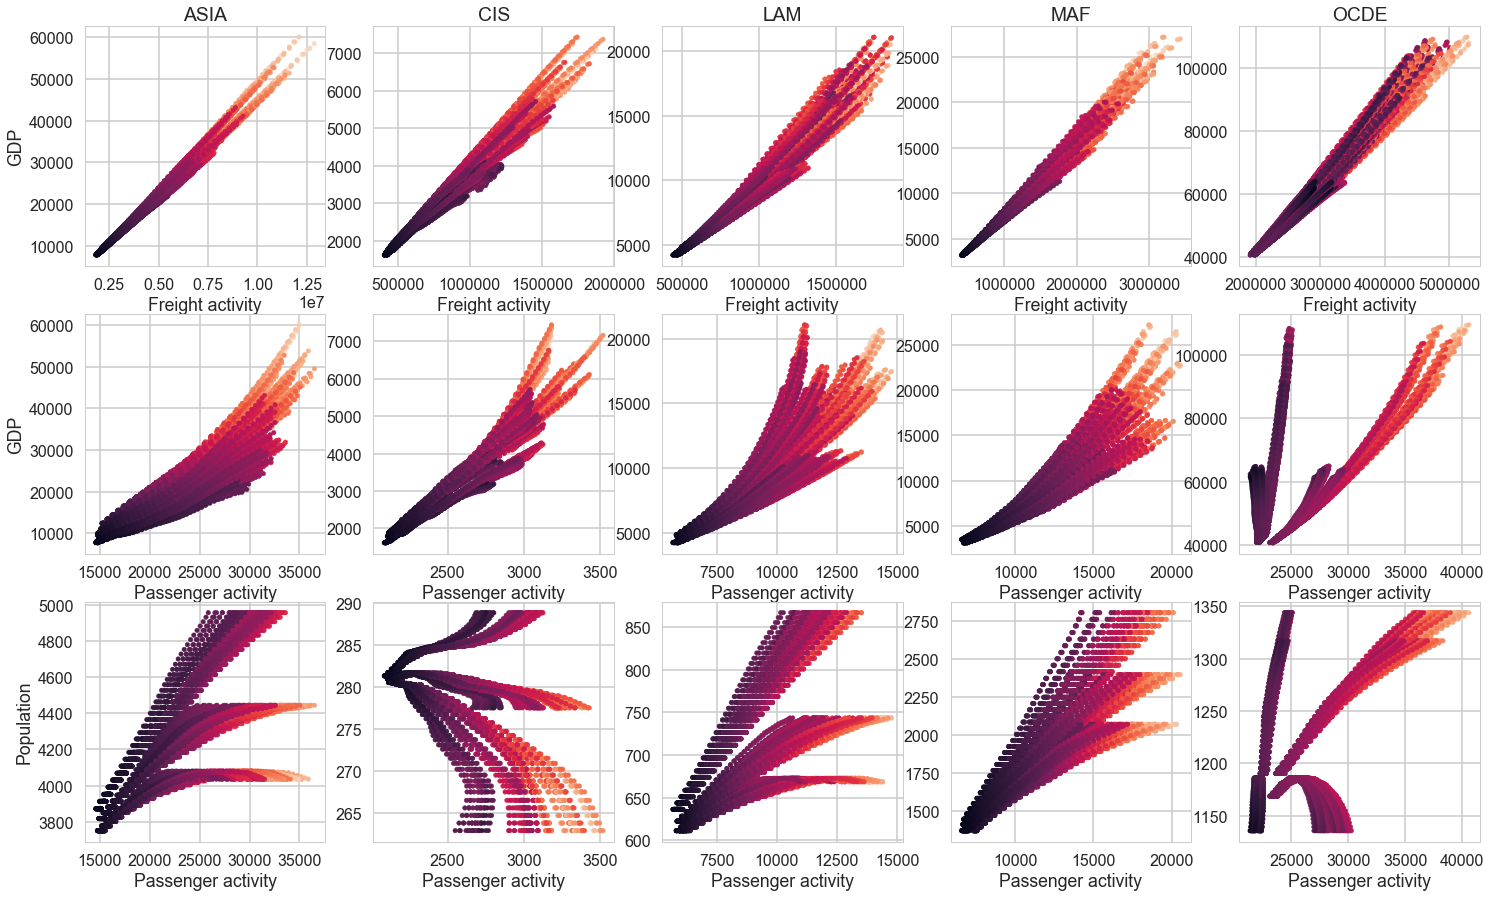

In [15]:
i=1
plt.figure(figsize=(25,15))
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.freight_activity,subframe.PIB,c=subframe.CO2_em_trans,s=20)
    plt.title(reg)
    plt.xlabel("Freight activity")
    if i==1:
        plt.ylabel("GDP")
    i=i+1
    
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.passenger_activity,subframe.PIB,c=subframe.CO2_em_trans,s=20)
    #plt.title(reg)
    plt.xlabel("Passenger activity")
    if i==6:
        plt.ylabel("GDP")
    i=i+1
    
for reg,subframe in out.groupby(level='region'):
    plt.subplot(3,5,i)
    plt.scatter(subframe.passenger_activity,subframe.Population,c=subframe.CO2_em_trans,s=20)
    #plt.title(reg)
    plt.xlabel("Passenger activity")
    if i==11:
        plt.ylabel("Population")
    i=i+1

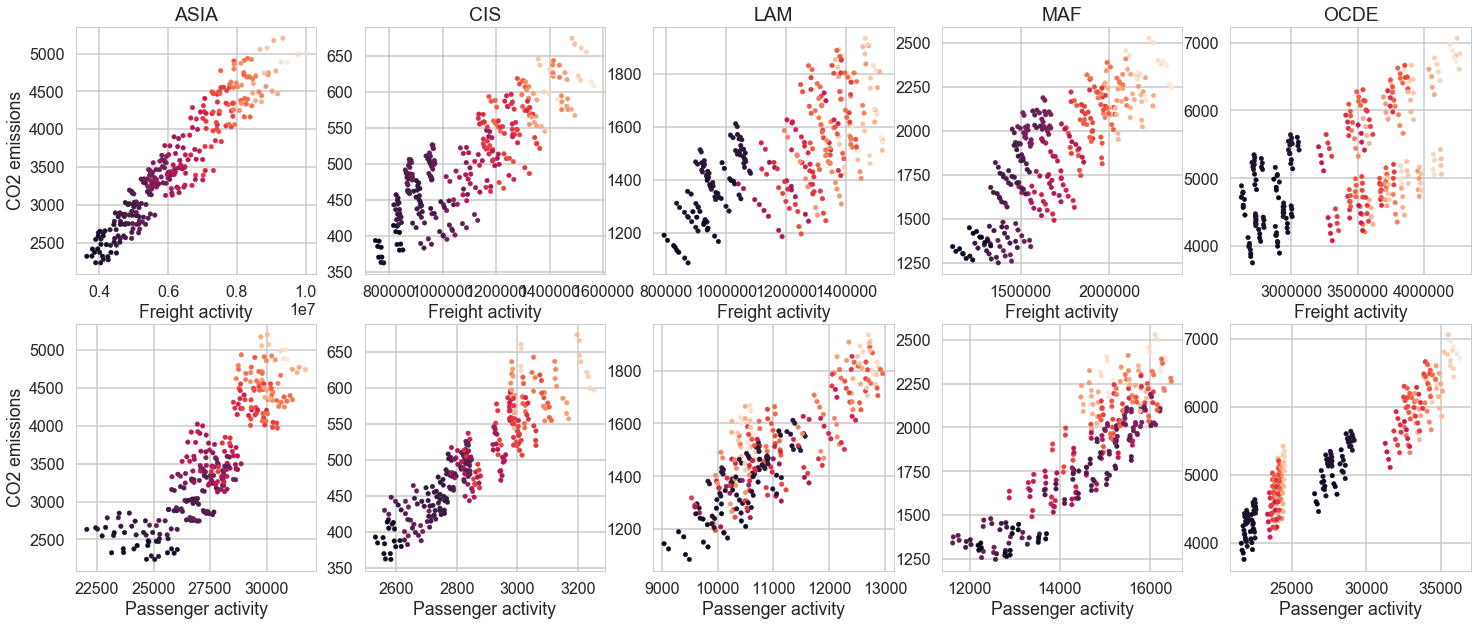

In [16]:
test = out.stack().unstack('year')['2040'].unstack('Variable')
i=1
plt.figure(figsize=(25,10))
for reg,subframe in test.groupby(level='region'):
    plt.subplot(2,5,i)
    plt.scatter(subframe.freight_activity,subframe.CO2_em_trans,c=subframe.PIB,s=20)
    plt.title(reg)
    plt.xlabel("Freight activity")
    if i==1:
        plt.ylabel("CO2 emissions")
    i=i+1
    
for reg,subframe in test.groupby(level='region'):
    plt.subplot(2,5,i)
    plt.scatter(subframe.passenger_activity,subframe.CO2_em_trans,c=subframe.PIB,s=20)
    plt.xlabel("Passenger activity")
    if i==6:
        plt.ylabel("CO2 emissions")
    #plt.title(reg)
    i=i+1

## Analysis of variance

In [21]:
from statsmodels.stats.anova import anova_lm
from statsmodels.formula.api import ols

In [22]:
def drivers_from_anova(varin,mydata):
    formula=varin+" ~ ind_climat+ind_growth+ind_mitig+ind_trans_A+ind_trans_S+ind_trans_I+ind_trans_F"
    olsmodel=ols(formula,data=mydata).fit()
    table=anova_lm(olsmodel)
    table['sum_sq_pc']=table['sum_sq']/table['sum_sq'].sum()
    table=table.sort_values(by=['sum_sq'],ascending=False)
    sumvar=0
    drivers=list()
    for var in table.index:
        if var!='Residual':
            drivers.append(var)
            sumvar+=table.loc[var,'sum_sq_pc']
        if len(drivers)==3:
            break
    return drivers,sumvar

In [39]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    drivers,sumvar = drivers_from_anova("freight_activity",subframe.reset_index())
    print(reg,drivers,sumvar)

ASIA ['ind_climat', 'ind_growth', 'ind_mitig'] 0.809600941775
CIS ['ind_growth', 'ind_climat', 'ind_trans_A'] 0.880509889341
LAM ['ind_growth', 'ind_climat', 'ind_trans_A'] 0.877322200566
MAF ['ind_climat', 'ind_growth', 'ind_mitig'] 0.844568944681
OCDE ['ind_growth', 'ind_trans_A', 'ind_climat'] 0.942191786704


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [60]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="ASIA",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).freight_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            8907375.0
Name: freight_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            4045781.25
Name: freight_activity, dtype: float64
-0.545794215468


In [61]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="CIS",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              1481125.0
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              798968.75
Name: freight_activity, dtype: float64
-0.460566292514


In [62]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="LAM",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              1497675.0
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              853506.25
Name: freight_activity, dtype: float64
-0.43011250772


In [63]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="MAF",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).freight_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            2227431.25
Name: freight_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            1223781.25
Name: freight_activity, dtype: float64
-0.450586297557


In [64]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="OCDE",:].set_index(['ind_growth', 'ind_climat', 'ind_trans_A']).freight_activity.mean(level=['ind_growth', 'ind_climat', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_growth  ind_climat  ind_trans_A
1           0           1              4168943.75
Name: freight_activity, dtype: float64
ind_growth  ind_climat  ind_trans_A
3           4           2              2664187.5
Name: freight_activity, dtype: float64
-0.360944243971


In [40]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    drivers,sumvar = drivers_from_anova("passenger_activity",subframe.reset_index())
    print(reg,drivers,sumvar)

ASIA ['ind_climat', 'ind_mitig', 'ind_growth'] 0.71639664777
CIS ['ind_climat', 'ind_growth', 'ind_mitig'] 0.777393792818
LAM ['ind_trans_S', 'ind_growth', 'ind_climat'] 0.664339620363
MAF ['ind_climat', 'ind_mitig', 'ind_trans_S'] 0.770647361065
OCDE ['ind_trans_S', 'ind_growth', 'ind_trans_A'] 0.933998366514


C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:875: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1814: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [65]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="OCDE",:].set_index(['ind_trans_S', 'ind_growth', 'ind_trans_A']).passenger_activity.mean(level=['ind_trans_S', 'ind_growth', 'ind_trans_A'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_trans_S  ind_growth  ind_trans_A
1            1           1              35203.916667
Name: passenger_activity, dtype: float64
ind_trans_S  ind_growth  ind_trans_A
2            3           2              21880.0625
Name: passenger_activity, dtype: float64
-0.378476471605


In [66]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="MAF",:].set_index(['ind_climat', 'ind_mitig', 'ind_trans_S']).passenger_activity.mean(level=['ind_climat', 'ind_mitig', 'ind_trans_S'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_mitig  ind_trans_S
0           2          1              16117.458333
Name: passenger_activity, dtype: float64
ind_climat  ind_mitig  ind_trans_S
4           1          2              12587.25
Name: passenger_activity, dtype: float64
-0.219030089008


In [67]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="LAM",:].set_index(['ind_trans_S', 'ind_growth', 'ind_climat']).passenger_activity.mean(level=['ind_trans_S', 'ind_growth', 'ind_climat'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_trans_S  ind_growth  ind_climat
1            1           0             12545.125
Name: passenger_activity, dtype: float64
ind_trans_S  ind_growth  ind_climat
2            3           4             9862.8125
Name: passenger_activity, dtype: float64
-0.213813134584


In [68]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="CIS",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).passenger_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            3117.875
Name: passenger_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           3           1            2576.1875
Name: passenger_activity, dtype: float64
-0.17373611835


In [69]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

test = test.reset_index()
means = test.ix[test.region=="ASIA",:].set_index(['ind_climat', 'ind_growth', 'ind_mitig']).passenger_activity.mean(level=['ind_climat', 'ind_growth', 'ind_mitig'])
print(means[means==means.max()])
print(means[means==means.min()])
print(means.min()/means.max()-1)

ind_climat  ind_growth  ind_mitig
0           1           2            30557.875
Name: passenger_activity, dtype: float64
ind_climat  ind_growth  ind_mitig
4           1           1            23923.0625
Name: passenger_activity, dtype: float64
-0.217122836585


## SOBOL

In [18]:
datat = out.stack().unstack('year')['2040'].unstack('Variable').reset_index()

In [16]:
uncertainties = ['ind_climat','ind_growth', 'ind_mitig','ind_trans_A', 'ind_trans_S',\
                'ind_trans_I','ind_trans_F']

In [19]:
for unc in uncertainties:
    print(datat[unc].unique())

[0 2 4]
[1 2 3]
[1 2]
[1 2]
[1 2]
[1 2]
[1 2]


In [20]:
problem = {'num_vars': len(uncertainties),'names': uncertainties,
    'bounds': [[-0.4999999,2.49999999],[0.5000001,3.49999999],[1, 2],[1,2], [1,2],[1,2], [1,2]]}

In [21]:
X=saltelli.sample(problem, 1000,calc_second_order=True)
X=X.round()

In [22]:
X_df = pd.DataFrame(X,columns=uncertainties)

In [66]:
X_df['ind_climat'] = X_df['ind_climat'].replace({-0:0,1:2,2:4})

In [26]:
from sobol_plot_functions import *

c:\users\wb451855\documents\rhodium\rhodium\sa.py:336: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.
  ax.set_axis_bgcolor('white')


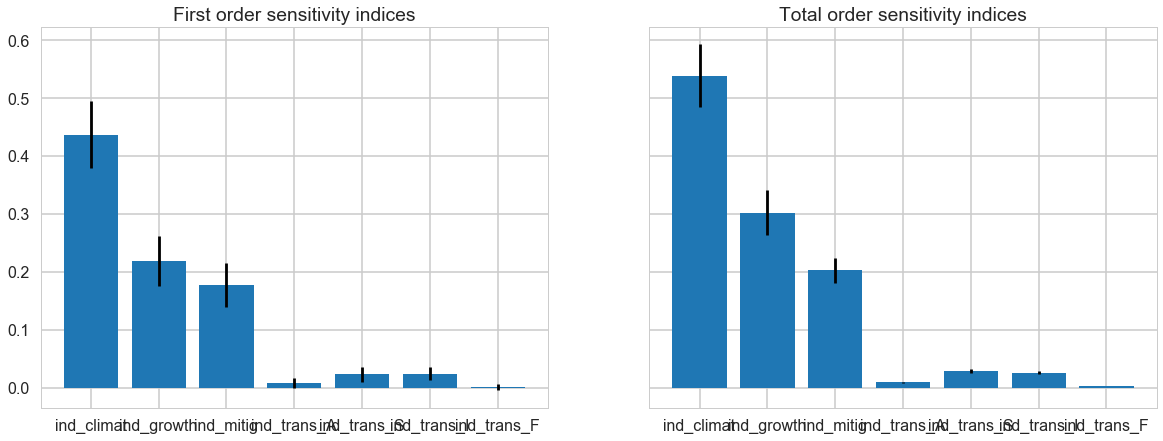

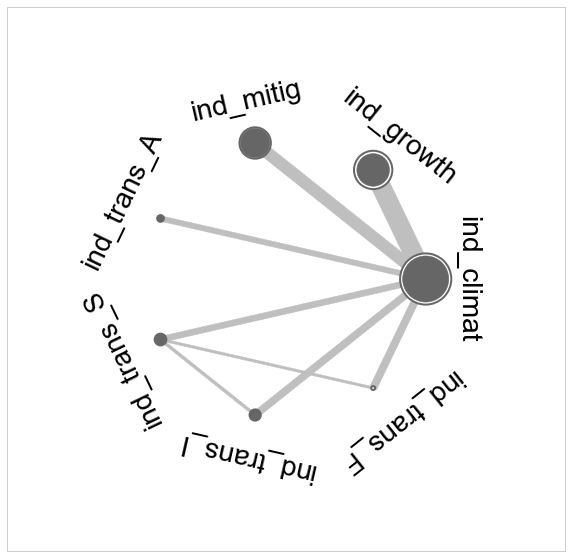

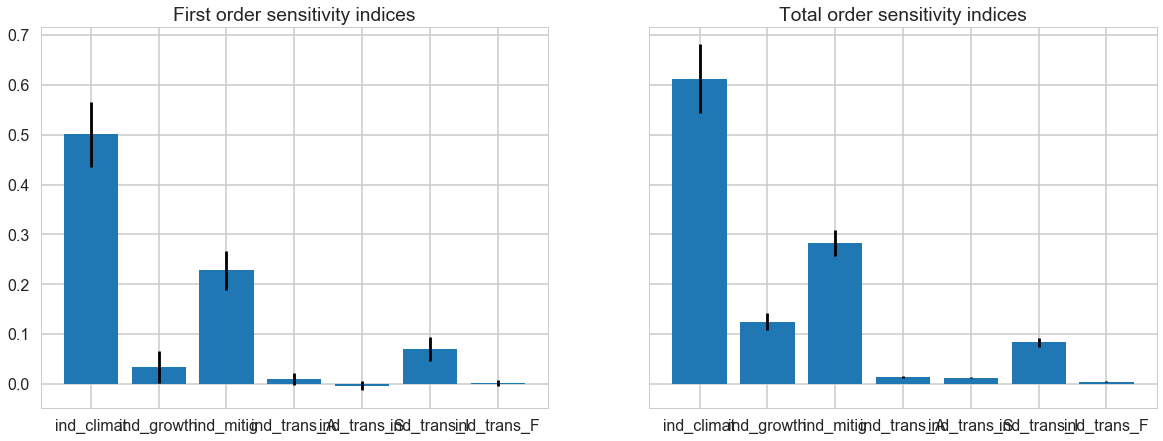

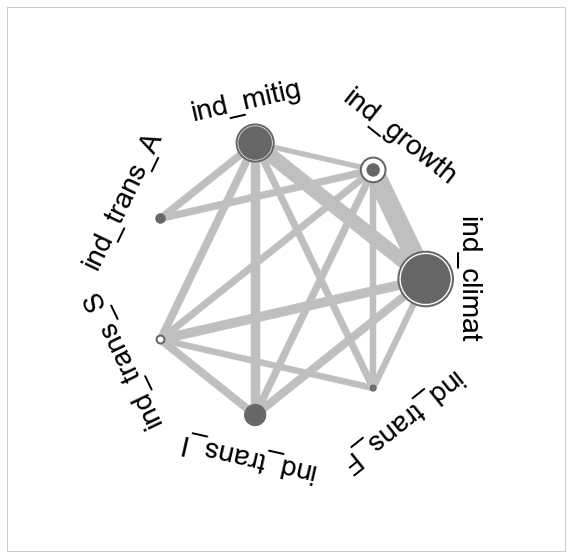

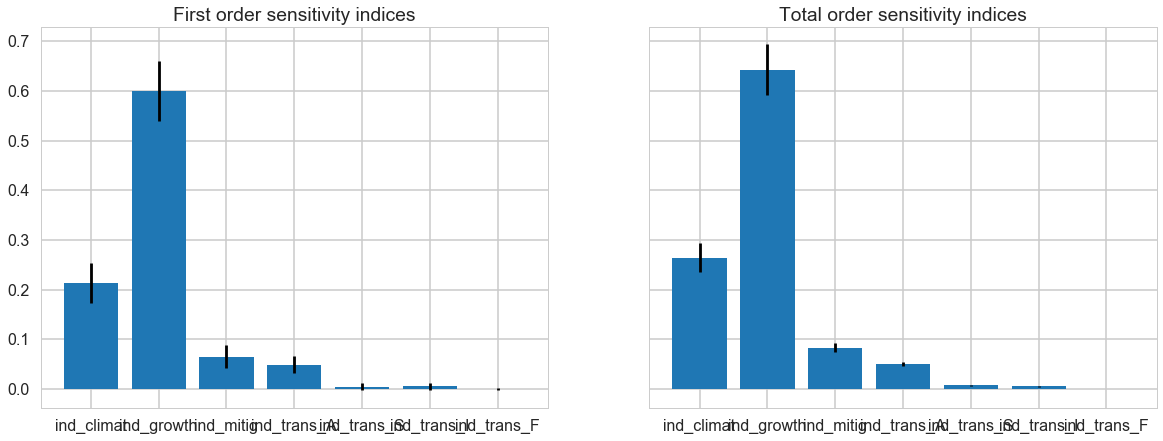

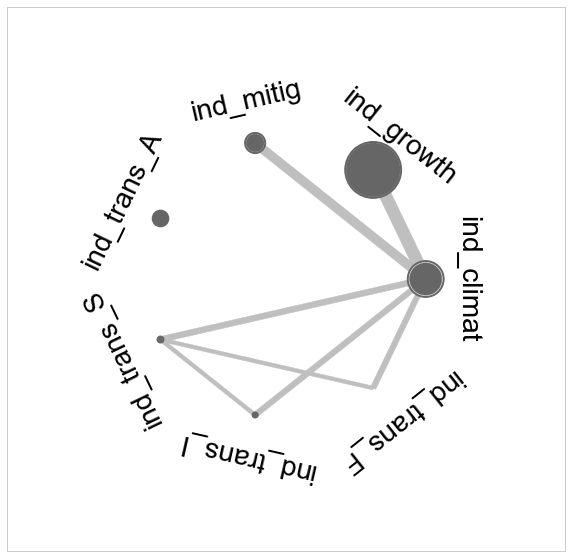

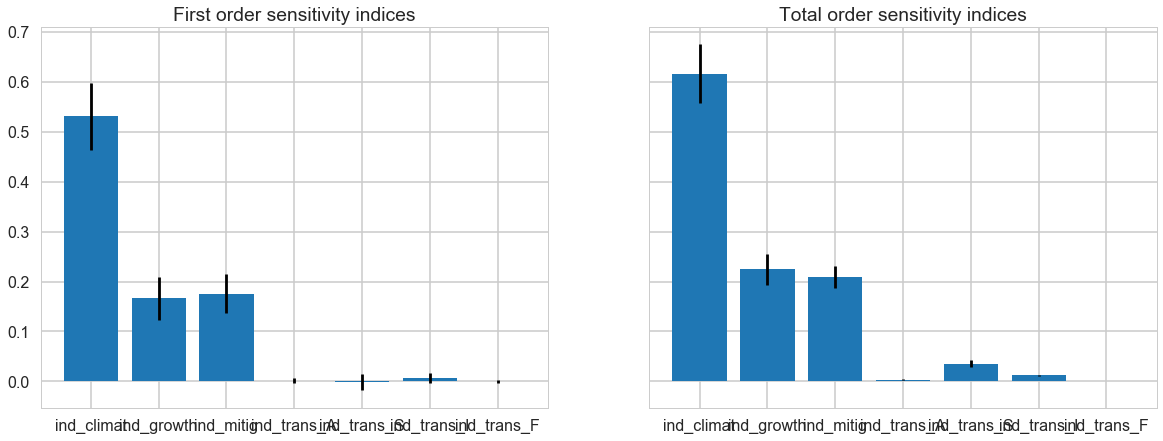

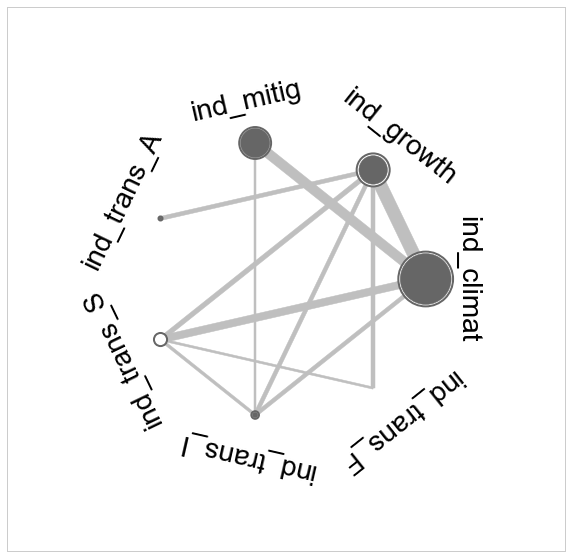

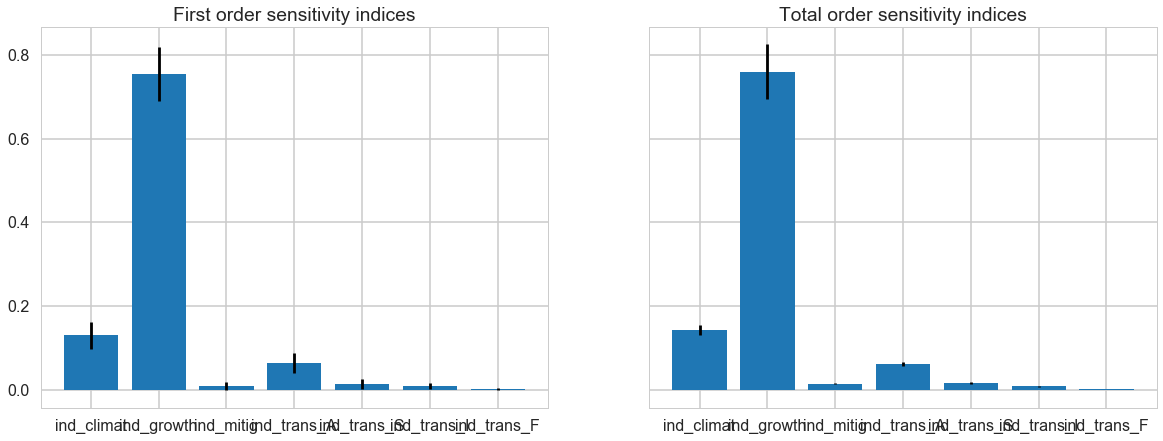

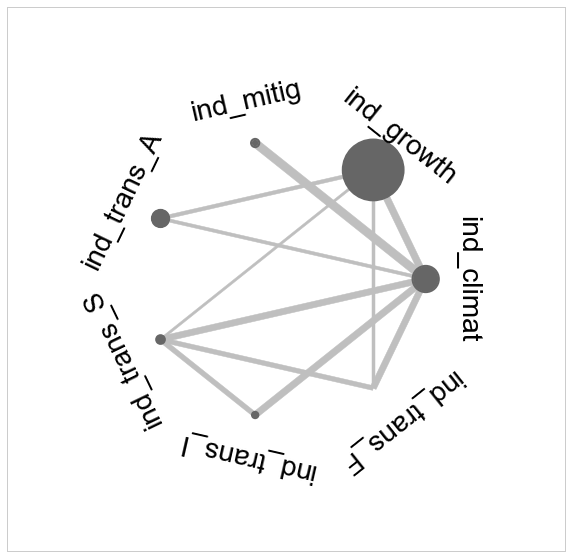

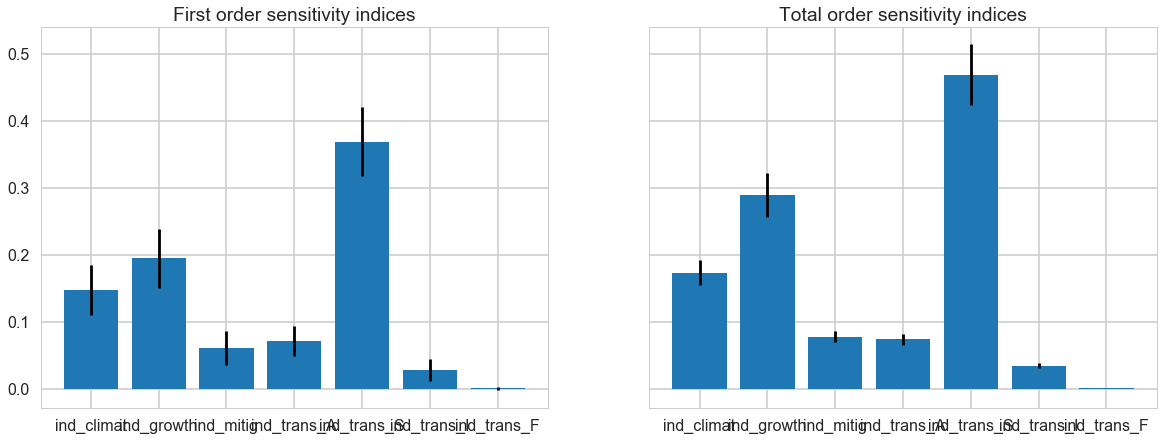

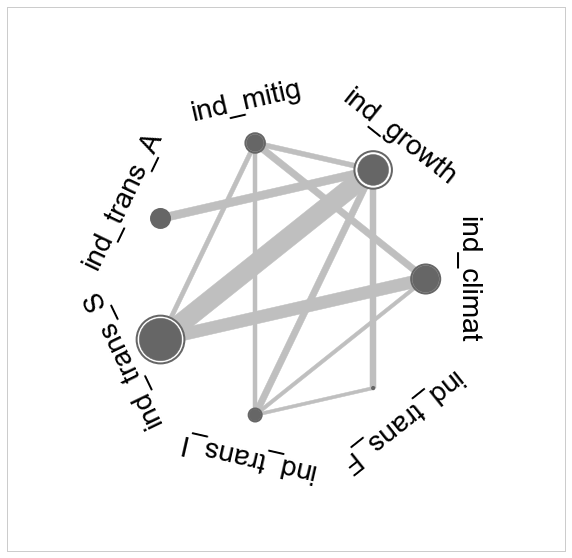

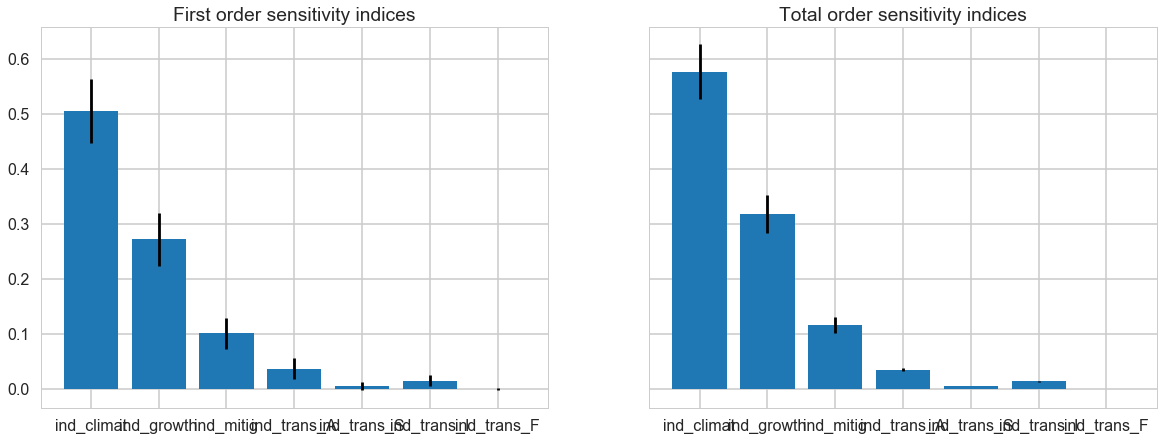

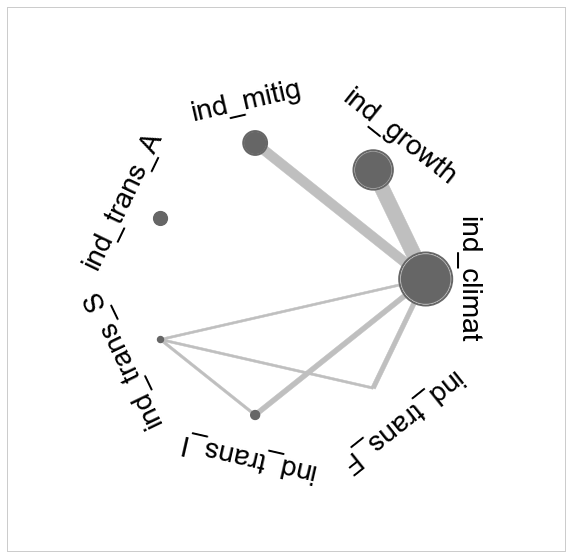

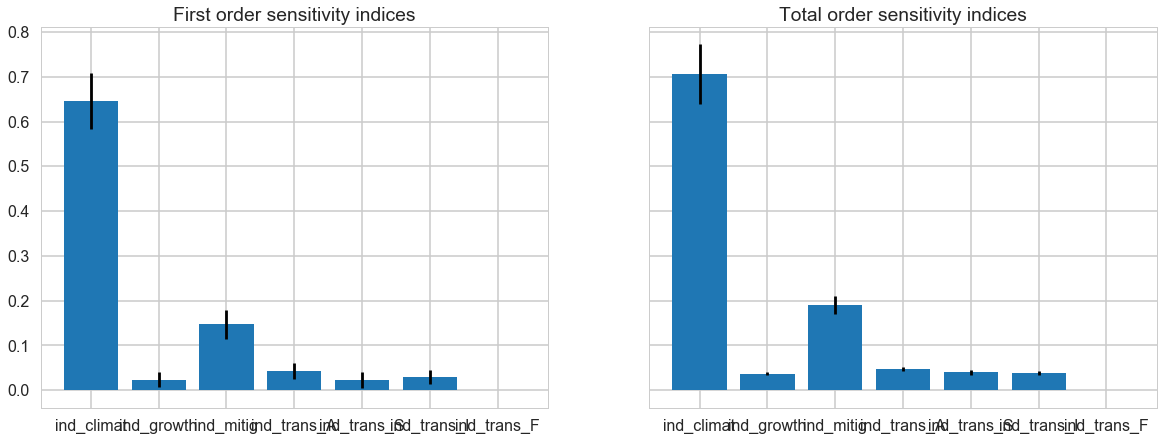

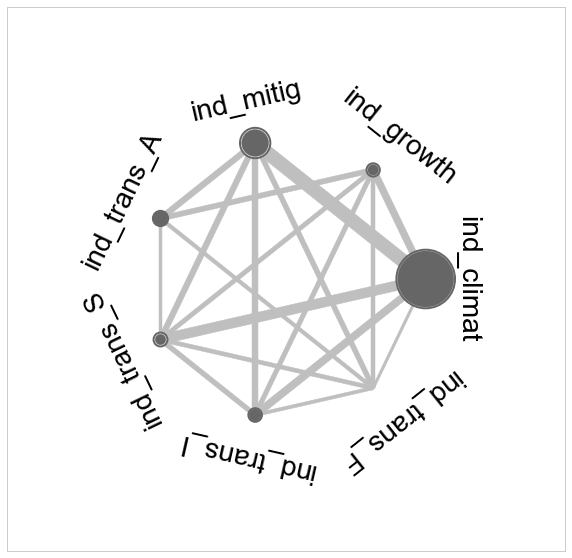

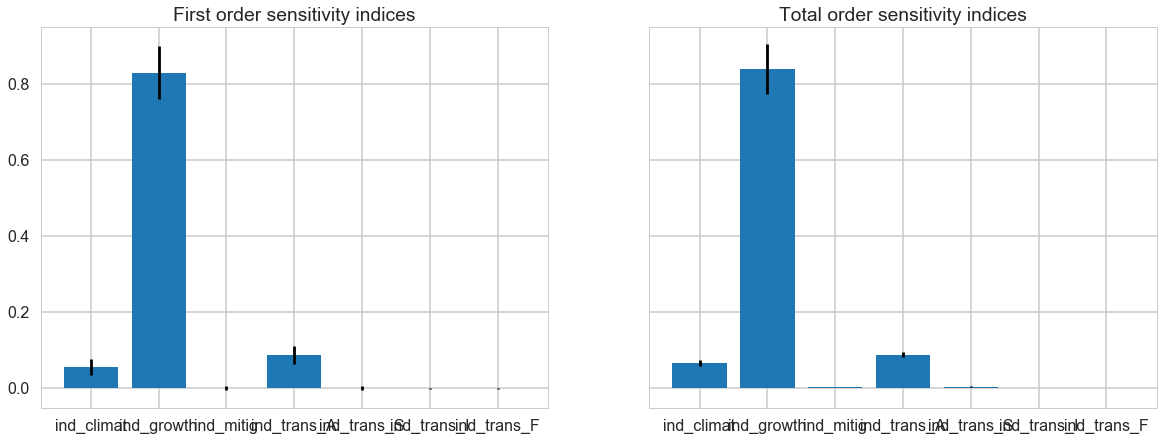

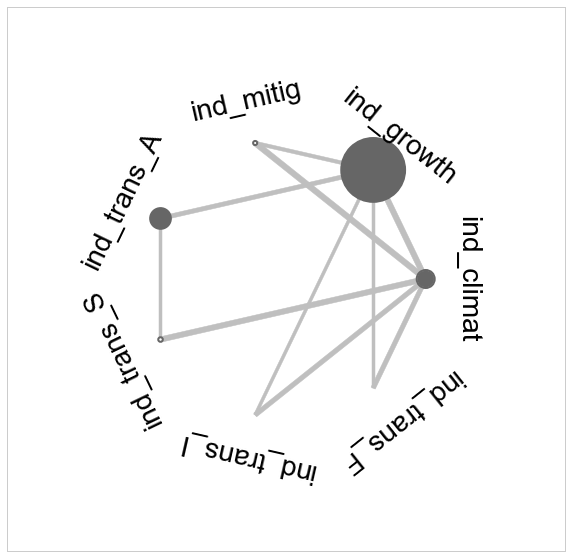

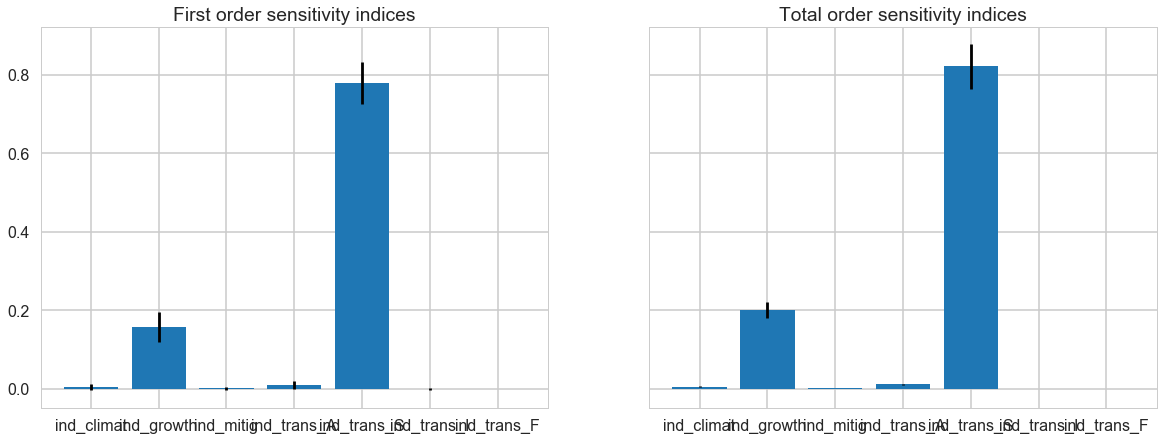

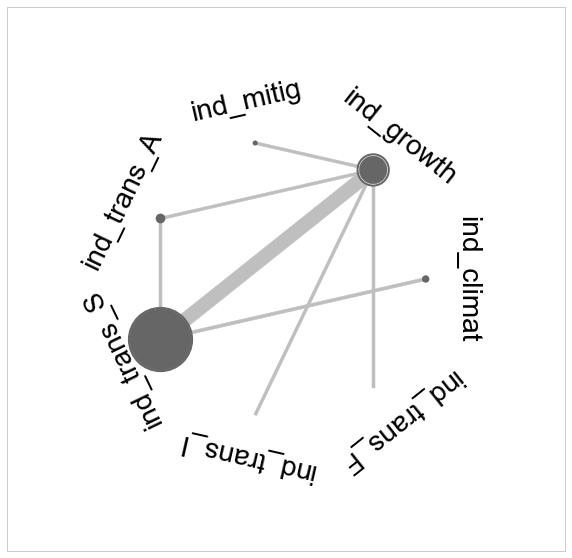

In [82]:
test = out.stack().unstack('year')['2040'].unstack('Variable')

for reg,subframe in test.groupby(level='region'):
    #I use pandas to merge the new inputs with the outputs since this is much much quicker. I use sort to make sure
    #I keep the order of the scenarios in X
    dataf = X_df.reset_index().merge(subframe.reset_index(),on=uncertainties,how="inner",sort=False).sort_values("index")
    
    Si_freight = sobol.analyze(problem, np.array(dataf["freight_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    np.savetxt('sobol\\S2_fret_'+reg+'.csv', Si_freight['S2'], delimiter=',')
    np.savetxt('sobol\\S2_conf_fret_'+reg+'.csv', Si_freight['S2_conf'], delimiter=',')
    np.savetxt('sobol\\S1_fret_'+reg+'.csv', Si_freight['S1'], delimiter=',')
    np.savetxt('sobol\\S1_conf_fret_'+reg+'.csv', Si_freight['S1_conf'], delimiter=',')
    np.savetxt('sobol\\ST_fret_'+reg+'.csv', Si_freight['ST'], delimiter=',')
    np.savetxt('sobol\\ST_conf_fret_'+reg+'.csv', Si_freight['ST_conf'], delimiter=',')
    
    Si_passenger = sobol.analyze(problem, np.array(dataf["passenger_activity"]), print_to_console=False, calc_second_order=True, conf_level=0.95)
    np.savetxt('sobol\\S2_pass_'+reg+'.csv', Si_passenger['S2'], delimiter=',')
    np.savetxt('sobol\\S2_conf_pass_'+reg+'.csv', Si_passenger['S2_conf'], delimiter=',')
    np.savetxt('sobol\\S1_pass_'+reg+'.csv', Si_passenger['S1'], delimiter=',')
    np.savetxt('sobol\\S1_conf_pass_'+reg+'.csv', Si_passenger['S1_conf'], delimiter=',')
    np.savetxt('sobol\\ST_pass_'+reg+'.csv', Si_passenger['ST'], delimiter=',')
    np.savetxt('sobol\\ST_conf_pass_'+reg+'.csv', Si_passenger['ST_conf'], delimiter=',')
    
    pretty_result_f = get_pretty_result(Si_freight,problem)
    fig11 = pretty_result_f.plot()
    fig11.set_size_inches(20, 7)
    fig11.savefig("sobol\\freight_"+reg+".png")
    fig12 = pretty_result_f.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig12.set_size_inches(10, 10)
    fig12.savefig("sobol\\freight_diagram_"+reg+".png")
    
    pretty_result_p = get_pretty_result(Si_passenger,problem)
    fig22 = pretty_result_p.plot()
    fig22.set_size_inches(20, 7)
    fig22.savefig("sobol\\passengers_"+reg+".png")
    fig22 = pretty_result_p.plot_sobol(radSc=2.0, scaling=1, widthSc=0.5, STthick=2, varNameMult=1.3, threshold=0.001)
    fig22.set_size_inches(10, 10)
    fig22.savefig("sobol\\passenger_diagram_"+reg+".png")

## discounted values (analysis not finished)

In [67]:
out = out.reset_index()
d = 0.03
out["discount_factor"] = (1+d)**(1-(out.year.astype(int)-2014))

In [68]:
out["discounted_pib"] = out.PIB*out.discount_factor

In [69]:
out.columns

Index(['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A', 'ind_trans_S',
       'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl', 'ind_taxmax',
       'region', 'year', 'CO2_em_tot', 'CO2_em_trans', 'PIB', 'Population',
       'freight_activity', 'fret_OT', 'fret_air', 'fret_mer',
       'passenger_activity', 'pkm_OT', 'pkm_air', 'pkm_auto',
       'discount_factor', 'discounted_pib'],
      dtype='object', name='Variable')

In [70]:
pib_summed_over_time = out.set_index([x for x in indexes_ima2 if x not in ["Variable"]]).discounted_pib.sum(level=[x for x in indexes_ima2 if x not in ["Variable","year"]])

# Now I look at a different dataset that contains investment needs

In [62]:
indexes_inv = ['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
        'ur_ideal', 'urt_ideal','delay','costs_evolution_road', 'costs_evolution_rail']

In [77]:
all_data = pd.DataFrame()
for reg in os.listdir(invfolder):
    for myfilename in os.listdir(invfolder+reg):
        myfile = pd.read_csv(invfolder+reg+"\\"+myfilename,sep=";")
        myfile = myfile.set_index(indexes_inv)
        myfile.columns.name='year'
        myfile = myfile.drop(['2050', '2051', '2052', '2053', '2054', '2055', '2056', '2057', '2058',
       '2059', '2060', '2061', '2062', '2063', '2064', '2065', '2066', '2067',
       '2068', '2069', '2070', '2071', '2072', '2073', '2074', '2075', '2076',
       '2077', '2078', '2079', '2080'],axis=1)
        myfile = myfile.stack('year')
        myfile.name = 'value'
        myfile = myfile.reset_index()
        myfile["discount_factor"] = (1+d)**(1-(myfile.year.astype(int)-2014))
        myfile['disc_value'] =  myfile['value']*myfile["discount_factor"]
        
        myfile = myfile.drop(["year","discount_factor"],axis=1).set_index(indexes_inv).sum(level=indexes_inv).reset_index()
        myfile['average_value'] = myfile['value']/(2049-2014)
        myinfo = myfilename.replace(".csv",'').split("_")
        myfile["costtype"] = myinfo[1]
        myfile["transpmode"] = myinfo[2]
        myfile["region"] = myinfo[3]
        all_data = all_data.append(myfile)

In [118]:
all_data.to_csv(invfolder+"summarize_costs.csv")

In [37]:
indexes_inv2 = ["costtype","transpmode","region"]

In [39]:
all_data = all_data.set_index(indexes_inv+indexes_inv2)

In [48]:
try1 = all_data.sum(level=indexes+["costtype"]).unstack("costtype")["total_cost"].reset_index()

In [77]:
try1.describe()

costtype,combi,ind_climat,ind_growth,ind_mitig,ind_trans_A,ind_trans_S,ind_trans_I,ind_trans_F,modal_scenario,costs_evolution_road,costs_evolution_rail,ur_ideal,urt_ideal,delay,maint,new
count,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000,62208.000000
mean,176.500000,2.000000,2.000000,1.500000,1.500000,1.500000,1.500000,1.500000,0.500000,1.000000,1.000000,600.000000,17500.000000,50.000000,92169.881534,58554.999784
std,122.898981,1.633006,0.816503,0.500004,0.500004,0.500004,0.500004,0.500004,0.500004,0.816503,0.816503,244.950943,12500.100471,15.000121,29250.315617,42162.016915
min,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,300.000000,5000.000000,35.000000,50123.080770,6307.147997
25%,72.750000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,300.000000,5000.000000,35.000000,71614.850097,27061.475699
50%,144.500000,2.000000,2.000000,1.500000,1.500000,1.500000,1.500000,1.500000,0.500000,1.000000,1.000000,600.000000,17500.000000,50.000000,87198.779651,44616.002838
75%,312.250000,4.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,900.000000,30000.000000,65.000000,104106.630671,79530.010817
max,384.000000,4.000000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,2.000000,2.000000,900.000000,30000.000000,65.000000,228156.429701,237140.349021
